In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
from qiskit.tools.visualization import plot_bloch_vector
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.amplitude_estimators import *
from qiskit.aqua.algorithms.amplitude_estimators.q_factory import QFactory
from qiskit.aqua.components.uncertainty_problems import UncertaintyProblem

In [2]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

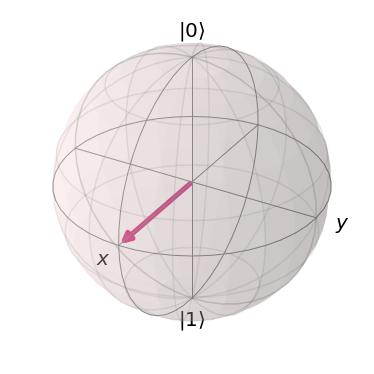

In [3]:
# the probability to be recovered
probability = 0.5
theta_p = 2*np.arcsin(np.sqrt(probability))

# the resulting quantum state after A is applied
plot_bloch_vector([np.sin(theta_p), 0.0, np.cos(theta_p)])

In [4]:
class BernoulliAFactory(UncertaintyProblem):
    """
    Circuit Factory representing the operator A.
    A is used to initialize the state as well as to construct Q.
    """
    
    def __init__(self, probability=0.5):
        # 
        super().__init__(1)
        self._probability = probability
        self.i_state = 0
        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
    
    def build(self, qc, q, q_ancillas=None):
        
        # A is a rotation of angle theta_p around the Y-axis
        qc.ry(self._theta_p, q[self.i_state])


class BernoulliQFactory(QFactory):
    """
    Circuit Factory representing the operator Q.
    This implementation exploits the fact that powers of Q can be implemented efficiently by just multiplying the angle.
    (amplitude estimation only requires controlled powers of Q, thus, only this method is overridden.)
    """
    
    def __init__(self, bernoulli_expected_value):
        super().__init__(bernoulli_expected_value, i_objective=0)
    
    def build(self, qc, q, q_ancillas=None):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta_p
        # Q is a rotation of angle 2*theta_p around the Y-axis
        qc.ry(2 * theta_p, q[i_state])
    
    def build_controlled_power(self, qc, q, q_control, power, q_ancillas=None, use_basis_gates=True):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta_p
        qc.cry(2*power*theta_p, q_control, q[i_state])

In [5]:
# construct factories for A and Q
bernoulli_a_factory = BernoulliAFactory(probability)
bernoulli_q_factory = BernoulliQFactory(bernoulli_a_factory)

In [ ]:
# construct factories for A and Q
theta_p = 2 * np.arcsin(np.sqrt(probability))

bernoulli_a = QuantumCircuit(1)
bernoulli_a.ry(theta_p, 0)
bernoulli_q = QuantumCircuit(1)
bernoulli_q.ry(2 * theta_p, 0)

### Iterative amplitude estimation

In [6]:
alpha = 0.05
eps_range = 10.0 ** np.arange(-1, -6, -1)
backend = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=100)

print(eps_range)

[1.e-01 1.e-02 1.e-03 1.e-04 1.e-05]


In [7]:
num_oracle_calls = []
error = []

for eps in eps_range:
    ae = IterativeAmplitudeEstimation(eps, alpha, state_preparation=bernoulli_a_factory, 
                                         grover_operator=bernoulli_q_factory)
    result = ae.run(backend)
    num_oracle_calls.append(result['num_oracle_queries'])
    error.append(result['actual_epsilon'])
    
for calls, err in zip(num_oracle_calls, error):
    print(calls, err)

0 0.03542174780515381
805.0 0.007296957754569705
15765.0 0.0005994476380150882
167012.0 6.596612952569636e-05
2003597.0 8.440203538601088e-06


In [11]:
np.save('iqae.npy', dict(zip(num_oracle_calls, error)), )

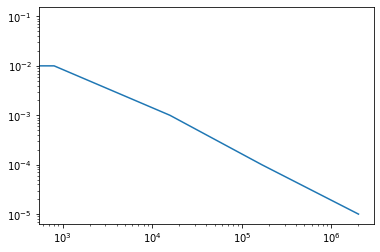

In [8]:
plt.loglog(num_oracle_calls, eps_range)

In [7]:
num_evaluation_qubits = list(range(1, 25))

error = []
num_oracle_calls = []

for m in num_evaluation_qubits:
    ae = AmplitudeEstimation(m, state_preparation=bernoulli_a_factory, 
                                         grover_operator=bernoulli_q_factory)
    result = ae.run(backend)
    num_oracle_calls.append(result['num_oracle_queries'])
    error.append(np.diff(result['95%_confidence_interval'])[0] / 2)
    
    print(m, num_oracle_calls[-1], error[-1])

1 100 0.09375548072559414
2 300 0.06896377559046304
3 700 0.030936245897149106
4 1500 0.015104165430750743
5 3100 0.007508559634136741
6 6300 0.0037488979470336747
7 12700 0.0018737780471110577
8 25500 0.0009368052142454675
9 51100 0.00046839213101912414
10 102300 0.00023419475763650222
11 204700 0.00011709721487482283
12 409500 5.8548585604750736e-05
13 819100 2.927429069829457e-05
14 1638300 1.4637145711232646e-05
15 3276700 7.318572275816226e-06
16 6553500 3.6592856054451506e-06
17 13107100 1.82964368403149e-06
18 26214300 9.148227215205473e-07
19 52428700 4.5740938284244415e-07
20 104857500 2.2870557064846864e-07
21 209715100 1.1435223595812616e-07
22 419430300 5.7175568585199343e-08
23 838860700 2.8588663519846236e-08
24 1677721500 1.4293782407692746e-08


In [8]:
np.vstack((num_oracle_calls, error))

array([[1.00000000e+02, 3.00000000e+02, 7.00000000e+02, 1.50000000e+03,
        3.10000000e+03, 6.30000000e+03, 1.27000000e+04, 2.55000000e+04,
        5.11000000e+04, 1.02300000e+05, 2.04700000e+05, 4.09500000e+05,
        8.19100000e+05, 1.63830000e+06, 3.27670000e+06, 6.55350000e+06,
        1.31071000e+07, 2.62143000e+07, 5.24287000e+07, 1.04857500e+08,
        2.09715100e+08, 4.19430300e+08, 8.38860700e+08, 1.67772150e+09],
       [9.37554807e-02, 6.89637756e-02, 3.09362459e-02, 1.51041654e-02,
        7.50855963e-03, 3.74889795e-03, 1.87377805e-03, 9.36805214e-04,
        4.68392131e-04, 2.34194758e-04, 1.17097215e-04, 5.85485856e-05,
        2.92742907e-05, 1.46371457e-05, 7.31857228e-06, 3.65928561e-06,
        1.82964368e-06, 9.14822722e-07, 4.57409383e-07, 2.28705571e-07,
        1.14352236e-07, 5.71755686e-08, 2.85886635e-08, 1.42937824e-08]])

In [9]:
np.save('ae.npy', dict(zip(num_oracle_calls, error)))
np.savetxt('ae.csv', np.vstack((num_oracle_calls, error)))

In [36]:
num_oracle_queries, error = np.loadtxt('ae.csv')

In [37]:
num_oracle_queries

array([1.02400000e+03, 3.07200000e+03, 7.16800000e+03, 1.53600000e+04,
       3.17440000e+04, 6.45120000e+04, 1.30048000e+05, 2.61120000e+05,
       5.23264000e+05, 1.04755200e+06, 2.09612800e+06, 4.19328000e+06,
       8.38758400e+06, 1.67761920e+07, 3.35534080e+07, 6.71078400e+07,
       1.34216704e+08, 2.68434432e+08, 5.36869888e+08, 1.07374080e+09,
       2.14748262e+09, 4.29496627e+09, 8.58993357e+09, 1.71798682e+10])

In [38]:
error

array([3.05808079e-02, 2.16445967e-02, 9.68266273e-03, 4.72492567e-03,
       2.34855647e-03, 1.17255904e-03, 5.86065208e-04, 2.93005833e-04,
       1.46499572e-04, 7.32493670e-05, 3.66246323e-05, 1.83123084e-05,
       9.15615474e-06, 4.57807557e-06, 2.28903711e-06, 1.14451802e-06,
       5.72259900e-07, 2.86130838e-07, 1.43064879e-07, 7.15333283e-08,
       3.57661241e-08, 1.78825221e-08, 8.94214960e-09, 4.47053486e-09])

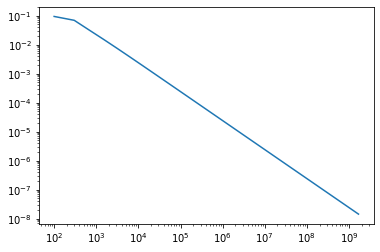

In [10]:
plt.loglog(num_oracle_calls, error)

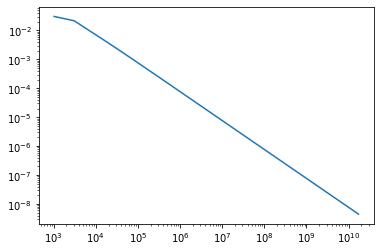

In [31]:
plt.loglog(num_oracle_calls, error)

In [39]:
from qiskit import QuantumCircuit

In [40]:
qc = QuantumCircuit(3)
qc.reset(qc.qubits)

In [41]:
qc.draw()

q_0: ─|0>─
          
q_1: ─|0>─
          
q_2: ─|0>─

In [11]:
result

{'counts': {'000000000000000000000010': 47, '000000000000000000000011': 53},
 'shots': 100,
 'a_items': [(0.5, 1.0)],
 'y_items': [(4194304, 0.47), (12582912, 0.53)],
 'mapped_values': [0.5],
 'values': [0.5],
 'y_values': [4194304, 12582912],
 'probabilities': [1.0],
 'mapped_items': [(0.5, 1.0)],
 'value': 0.5,
 'estimation': 0.5,
 'max_probability': 1.0,
 'num_oracle_queries': 1677721500,
 'ml_value': 0.5,
 'mle': 0.5,
 '95%_confidence_interval': [0.49999998570621756, 0.5000000142937824]}

'counts': counts (or statevector) simulation result
'shots': number of shots
'a_items': List[Tuple[a_value, probability]],
'y_items': List[Tuple[y_value, probability]],
'mapped_values': List[post_processing(a_value)],
'values': List[a_value],
'y_values': List[y_value],
'probabilities': List[probability],
'mapped_items': List[Tuple[post_processing(a_value), probability]],
'value': a_value with highest prob
'estimation': post_processing(a_value with highest prob)
'max_probability': highest prob
'num_oracle_queries': N_orac
'ml_value': MLE for a value
'mle': post_processing(MLE for a value)
'95%_confidence_interval': likelihood ratio CI

replace counts/statevector key to have one key for both -> 'circuit_result'
number of shots -> 'shots'
y_items (integer values and meas. probability) -> 'y_measurements'
a_items (y values mapped to [0,1] and probability) -> 'a_samples'
mapped a_items (post processing applied to a values) -> 'mapped_a_samples'
a_value with highest prob -> 'a_estimation' (instead of 'value') 
mapped a_value -> 'estimation'
highest prob -> 'max_probability'
N_orac -> 'num_oracle_queries'
MLE for a value -> 'mle_a'
post_processing(MLE for a value) - >'mle'
likelihood ratio CI -> '95%_confidence_interval'